In [46]:
# first importing necessary modules
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [47]:
# memory optimization in Pytorch
# in training large models to reduce memory fragmentation we use 
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device optimization


In [48]:
print(device) # currently for my laptop pytorch installed is in cpu 

cpu


In [49]:
# defining variables
wavelength = 1.0 # arbitrary units
k = 2*np.pi/wavelength # wave number 
d = wavelength/4 # spacing decided to reduce side lobes
M,N = 16,16 # metasurface array dimension so it have 16* 16 emitter with d spacing between adjacent one
resolution = 128 # dont get what exactly it is
num_samples = 10 # total sample number 

epochs = 100 # training epoch 
batch_size = 64


In [68]:
# now we will need to define position for each array in metasurface
X = np.arange(M)*d # array like [0,d,2d,3d ....]
y = np.arange(N)*d # similar array as for X
X_grid, y_grid = np.meshgrid(X,y,indexing='ij')
print(X_grid)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25]
 [0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5 ]
 [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.  ]
 [1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25
  1.25 1.25]
 [1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5
  1.5  1.5 ]
 [1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75
  1.75 1.75]
 [2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
  2.   2.  ]
 [2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25
  2.25 2.25]
 [2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5
  2.5  2.5 ]
 [2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75
  

In [51]:
# creating angular grid 
theta = torch.linspace(0,np.pi/3, resolution, device =device)
phi = torch.linspace(0,2*np.pi,resolution, device = device)
theta_grid , phi_grid = torch.meshgrid(theta,phi,indexing='ij')


In [52]:
# getting sin and cosine now 
sin_theta = torch.sin(theta_grid)
cos_theta = torch.cos(theta_grid)
sin_phi = torch.sin(phi_grid)
cos_phi = torch.cos(phi_grid)


In [53]:
# making 16*16 X_grid and y_grid to one d array of 256 element each
x_flat = X_grid.flatten()
y_flat = y_grid.flatten()

In [69]:
print(X_grid)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25]
 [0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5 ]
 [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
  0.75 0.75]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.  ]
 [1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25
  1.25 1.25]
 [1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5
  1.5  1.5 ]
 [1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75 1.75
  1.75 1.75]
 [2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
  2.   2.  ]
 [2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25 2.25
  2.25 2.25]
 [2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5
  2.5  2.5 ]
 [2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75 2.75
  

In [55]:
print(x_flat.shape)

(256,)


In [56]:
# torch.cuda.memory_summary() can use if cuda is there 

In [57]:
if device.type == 'cpu': # for cpu
  import psutil

  # CPU usage percentage over 1 second interval
  print("CPU usage (%):", psutil.cpu_percent(interval=1))

  # Overall RAM usage stats
  ram = psutil.virtual_memory()
  print("RAM usage (%):", ram.percent)
  print("RAM used (GB):", round(ram.used / 1e9, 2))

else:
  torch.cuda.memory_summary()# for cuda


CPU usage (%): 1.2
RAM usage (%): 80.2
RAM used (GB): 13.52


In [61]:
# getting target intensity from user position using formoula given in paper
def calculate_far_field(user_positions, resolution=32):
    theta_vals = np.linspace(0, np.pi / 2, resolution)
    phi_vals = np.linspace(0, 2 * np.pi, resolution)
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij")
    intensity = np.zeros_like(theta_grid)

    for theta_u, phi_u in user_positions:
        sinc_x = np.sinc(k * N * d / 2 *(np.sin(theta_grid) * np.cos(phi_grid) - np.sin(theta_u) * np.cos(phi_u)))
        sinc_y = np.sinc(k * M * d / 2 *(np.sin(theta_grid) * np.sin(phi_grid) - np.sin(theta_u) * np.sin(phi_u)))
        intensity += (np.cos(theta_grid)**2) * (np.abs(sinc_x * sinc_y)**2)
    print(intensity/len(user_positions))
    return intensity.flatten()/ len(user_positions) 


In [62]:
# getting far field intensity for a given phase 
def intensity_from_phase(phase):
  phase_flat =  phase.flatten()
  phase_term = k*(x_flat[:,None,None]*cos_phi[None,None,:]*sin_theta[None,None,:] + y_flat[:,None,None]*sin_phi[None,None,:]*sin_theta[None,None,:]) - phase_flat[:,None,None]
  exp_term = torch.exp(1j*phase_term) # 1j represent complex emponential
  exp_term = torch.sum(exp_term,dim=0)
  final_Int = (cos_theta**2)*(torch.abs( exp_term**2))

  return final_Int.flatten()

# considering A to be 1 in this whole calculation


In [63]:
# what data that we are gonna get is user positon and nothing else i think 
# so first we got target intensity, and then got intensity from phase 
# now we need NN to convert this target intensity to phase profile 
import torch
x = torch.arange(10)*5
y = torch.arange(10)*5
x_grids, y_grids = torch.meshgrid(x,y,indexing='ij')
print(x)
print(y)
print(x_grids)
print(x_grids.flatten())

tensor([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])
tensor([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
        [30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
        [35, 35, 35, 35, 35, 35, 35, 35, 35, 35],
        [40, 40, 40, 40, 40, 40, 40, 40, 40, 40],
        [45, 45, 45, 45, 45, 45, 45, 45, 45, 45]])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
 

In [79]:
import torch.nn as nn
class Phasepredictor(nn.Module):
  def __init__(self):
    super(Phasepredictor,self).__init__()
    self.fc = nn.Sequential(
      nn.Linear(resolution*resolution, 4096), #input is resolution *resolution because our target intesity will be input to this nn which is resolution **2 
      nn.LeakyReLU(0.01),
      nn.Linear(4096,4096),
      nn.LeakyReLU(0.01),
      nn.Linear(4096, M*N),
          
    )
    self._initialize_weights()

  def forward(self, x):
    return self.fc(x)
  def _initialize_weights(self):
    for layer in self.fc:
      if isinstance(layer,nn.Linear):
        nn.init.xavier_uniform(layer.weight)
        nn.init.zeros_(layer.bias)


In [67]:
# Keep theta within 0 and 60 
# so here we are taking randomly user position and putting in the function for target intensity to get our tarining data, in range 1 becuase for 1 user.
user_positions_list = [[(np.random.uniform(0, np.pi / 3), np.random.uniform(0, 2 * np.pi)) for _ in range(3)] for _ in range(9)]
intensity_profiles = torch.tensor(np.array([calculate_far_field(up, resolution=resolution) for up in user_positions_list] ),dtype=torch.float32).to(device)
print(intensity_profiles.shape)


[[3.31274459e-01 3.31274459e-01 3.31274459e-01 ... 3.31274459e-01
  3.31274459e-01 3.31274459e-01]
 [3.19658317e-01 3.19719877e-01 3.19747523e-01 ... 3.19434208e-01
  3.19563021e-01 3.19658317e-01]
 [2.61615950e-01 2.61724922e-01 2.61794490e-01 ... 2.61281538e-01
  2.61468194e-01 2.61615950e-01]
 ...
 [1.31563614e-07 3.07768147e-08 4.11369702e-09 ... 4.34778451e-09
  2.91654011e-08 1.31563614e-07]
 [3.28415090e-08 7.68345846e-09 1.03229205e-09 ... 1.09024561e-09
  7.28105968e-09 3.28415090e-08]
 [8.04486993e-37 1.88220981e-37 2.53314459e-38 ... 2.67470955e-38
  1.78362582e-37 8.04486993e-37]]
[[1.76301606e-03 1.76301606e-03 1.76301606e-03 ... 1.76301606e-03
  1.76301606e-03 1.76301606e-03]
 [4.97219944e-04 5.02578311e-04 5.10445331e-04 ... 4.93842342e-04
  4.94322257e-04 4.97219944e-04]
 [3.80478449e-05 3.85641449e-05 3.75424106e-05 ... 3.25740656e-05
  3.60016321e-05 3.80478449e-05]
 ...
 [1.32688128e-07 5.90320697e-08 3.76107231e-09 ... 4.56123951e-09
  1.01341209e-08 1.32688128e-07]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = 12
users_per_sample = 3
N = 128                           # Grid size for smooth images
thetas = np.linspace(0, np.deg2rad(70), N)      # [0, 70°] in radians
phis = np.linspace(0, 2 * np.pi, N)             # [0, 2π] in radians

# Prepare meshgrid for plotting (polar coordinates projected to cartesian)
R_grid, Phi_grid = np.meshgrid(np.rad2deg(thetas), phis, indexing='ij')  # [N, N]
X_plot = R_grid * np.cos(Phi_grid)  # [N, N]
Y_plot = R_grid * np.sin(Phi_grid)  # [N, N]

ring_degrees = [10, 20, 30, 40, 50, 60, 70]

# Collect all intensity patterns
all_imgs = []
for _ in range(num_samples):
    theta_users, phi_users = generate_random_user_positions(U=users_per_sample)
    img = target_intensity_pattern(theta_users, phi_users, N=N).cpu().numpy()  # Should output shape [N, N]
    all_imgs.append(img)

vmax = np.percentile([img.max() for img in all_imgs], 99)  # For nice color contrast

# Plotting
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
axes = axes.flatten()
rmax = np.rad2deg(thetas[-1])
for idx, ax in enumerate(axes):
    img = all_imgs[idx]
    # Plot with pcolormesh mapping θ and φ to x, y
    im = ax.pcolormesh(X_plot, Y_plot, img, cmap='jet', vmin=0, vmax=vmax, shading='auto')
    # Draw polar rings and labels
    for rg in ring_degrees:
        circ = plt.Circle((0, 0), rg, color='white', fill=False, lw=1, alpha=0.7)
        ax.add_artist(circ)
        # Place the label slightly inside each ring
        ax.text(rg * np.cos(np.deg2rad(23)), rg * np.sin(np.deg2rad(23)), f"{rg}",
                color='white', fontsize=10, ha='left', va='bottom', alpha=0.7)
    ax.set_xlim(-rmax-2, rmax+2)
    ax.set_ylim(-rmax-2, rmax+2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title(f"Sample {idx+1}", fontsize=12)

fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.18, 0.015, 0.65])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("Intensity [arb. units]", fontsize=13)
cb.ax.tick_params(labelsize=11)
plt.suptitle("Target Intensity Patterns (Flat Polar), 12 Samples, 3 Users Each", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()


In [ ]:
# making train and tst data
train_size = int(0.8*num_samples)
X_train, X_test = intensity_profiles[:train_size] , intensity_profiles[train_size:]
X_train =  torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

model = Phasepredictor().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

def compute_loss(input_intensity, predicted_phase):
  theta_grid, phi_grid = torch.meshgrid(theta,phi,indexing = 'ij')
  predicted_intensity = intensity_from_phase(predicted_phase.reshape(M,N))
  weights  = torch.exp(8*torch.log*torch.tensor(2.0).to(device))(theta_grid/np.pi/2)
  weighted_diff = weights*(predicted_intensity-input_intensity.reshape(resolution,resolution))**2
  return torch.mean(weighted_diff)
for epoch in range(epochs):
  model.train()
  total_loss = 0
  
  new_user_positions_list = [[(np.random.uniform(0, np.pi / 3), np.random.uniform(0, 2 * np.pi)) for _ in range(3)] for _ in range(num_samples)]
  new_intensity_profiles = torch.tensor(np.array([far_field(up, resolution=resolution) for up in new_user_positions_list]), dtype=torch.float32).to(device)
    
permutation = torch.randperm(X_train.size(0))
selected_X_train = X_train[permutation[:batch_size]]

combined_X_train = torch.cat((selected_X_train, new_intensity_profiles), dim=0)

optimizer.zero_grad()
predicted_phase = model(combined_X_train)
loss = sum(compute_loss(combined_X_train[j], predicted_phase[j]) for j in range(combined_X_train.size(0))) / combined_X_train.size(0)
loss.backward()
optimizer.step()

total_loss += loss.item()  # Accumulate loss for the epoch
print("Epoch", epoch + 1, "of", epochs, "Loss", total_loss)
torch.cuda.empty_cache()

with torch.no_grad():
    X_train = torch.cat((X_train.cpu(), new_intensity_profiles.cpu()), dim=0).to(device)
if X_train.size(0) > 5000:
    X_train = X_train[-5000:]
if epoch % 500 == 0:
    torch.save(model.state_dict(), f"trained_model_{epoch}_{learning_rate}_{M}_{resolution}.pth")
    print("Model parameters saved!")

torch.cuda.memory_summary()
model.eval()
torch.cuda.empty_cache()
with torch.no_grad():
    test_idx = 0
    input_intensity = X_test[test_idx].reshape(resolution, resolution).cpu().numpy()
    predicted_phase = model(X_test[test_idx].unsqueeze(0)).cpu().numpy().reshape(M, N)
    predicted_intensity = intensity_from_phase(torch.tensor(predicted_phase, dtype=torch.float32).to(device)).reshape(resolution, resolution).cpu().numpy()

torch.save(model.state_dict(), f"trained_model_{epochs}_{learning_rate}_{M}_{resolution}.pth")
print("Model parameters saved!")




# Load model parameters from a .pth file of parameters
model_path = 'trained_model_8000_0.0001_32_128.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

print("Model parameters loaded successfully.")

with torch.no_grad():
    test_idx = 0
    input_intensity = X_test[test_idx].reshape(resolution, resolution).cpu().numpy()
    predicted_phase = model(X_test[test_idx].unsqueeze(0)).cpu().numpy().reshape(M, N)
    predicted_intensity = intensity_from_phase(torch.tensor(predicted_phase, dtype=torch.float32).to(device)).reshape(resolution, resolution).cpu().numpy()

    theta_vals = np.linspace(0, np.pi / 2, resolution)
    phi_vals = np.linspace(0, 2 * np.pi, resolution)
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij")

    # Plot results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1, projection='polar')
    plt.title("Input Intensity")
    plt.pcolormesh(phi_grid, theta_grid, input_intensity, cmap="inferno")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Predicted Phase")
    plt.imshow(predicted_phase % (2 * np.pi), cmap="plasma")
    plt.colorbar()

    plt.subplot(1, 3, 3, projection='polar')
    plt.title("Resulting Intensity")
    plt.pcolormesh(phi_grid, theta_grid, predicted_intensity, cmap="inferno")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # Evaluate using more samples
    num_test_samples = 10
    test_indices = np.random.choice(len(X_test), num_test_samples, replace=False)

    plt.figure(figsize=(15, 50))

    for idx, test_idx in enumerate(test_indices):
        input_intensity = X_test[test_idx].reshape(resolution, resolution).cpu().numpy()
        predicted_phase = model(X_test[test_idx].unsqueeze(0)).cpu().numpy().reshape(M, N)
        predicted_intensity = intensity_from_phase(torch.tensor(predicted_phase, dtype=torch.float32).to(device)).reshape(resolution, resolution).cpu().numpy()

        theta_vals = np.linspace(0, np.pi / 2, resolution)
        phi_vals = np.linspace(0, 2 * np.pi, resolution)
        theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij")

        # Plot results
        plt.subplot(num_test_samples, 3, idx * 3 + 1, projection='polar')
        plt.title(f"Input Intensity {idx+1}")
        plt.pcolormesh(phi_grid, theta_grid, input_intensity, cmap="inferno")
        plt.colorbar()

        plt.subplot(num_test_samples, 3, idx * 3 + 2)
        plt.title(f"Predicted Phase {idx+1}")
        plt.imshow(predicted_phase % (2 * np.pi), cmap="plasma")
        plt.colorbar()

        plt.subplot(num_test_samples, 3, idx * 3 + 3, projection='polar')
        plt.title(f"Resulting Intensity {idx+1}")
        plt.pcolormesh(phi_grid, theta_grid, predicted_intensity, cmap="inferno")
        plt.colorbar()

    plt.tight_layout()
    plt.show()
    #memory code
    # permutation = torch.randperm(X_train.size(0))
    # selected_x_train  = X_train(permutation[:batch_size])


  
  

C:\Users\binda\AppData\Local\Temp\ipykernel_23584\3793242042.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train =  torch.tensor(X_train, dtype=torch.float32).to(device)
C:\Users\binda\AppData\Local\Temp\ipykernel_23584\3793242042.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
C:\Users\binda\AppData\Local\Temp\ipykernel_23584\3047610312.py:20: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(layer.weight)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (115x0 and 16384x4096)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Enable PyTorch memory optimization
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# User-defined parameters
lambda_wave = 1.0  # Wavelength (arbitrary units)
k = 2 * np.pi / lambda_wave  # Wave number
d = lambda_wave / 4  # Inter-element spacing
M, N = 16,16  # Array dimensions for testing
resolution = 128  # Resolution for far-field calculations
num_samples = 64  # Number of total synthetic samples
epochs = 100  # Number of training epochs
batch_size = 64  # Reduced batch size

# Derived constants
x_coords = np.arange(M) * d
y_coords = np.arange(N) * d
x_grid, y_grid = np.meshgrid(x_coords, y_coords, indexing="ij")
x_grid = torch.tensor(x_grid, dtype=torch.float32).to(device)
y_grid = torch.tensor(y_grid, dtype=torch.float32).to(device)


# Create angular grids
theta_vals = torch.linspace(0, np.pi / 2, resolution, device=device)
phi_vals = torch.linspace(0, 2 * np.pi, resolution, device=device)
theta_grid, phi_grid = torch.meshgrid(theta_vals, phi_vals, indexing='ij')  # [res, res]

# Precompute trigonometric terms
sin_theta = torch.sin(theta_grid)      # [res, res]
cos_theta = torch.cos(theta_grid)      # [res, res]
cos_phi = torch.cos(phi_grid)        # [res, res]
sin_phi = torch.sin(phi_grid)        # [res, res]
# Flatten aperture grid
x_flat = x_grid.flatten()              # [N]
y_flat = y_grid.flatten()              # [N]

def calculate_far_field(user_positions, resolution=32):
    theta_vals = np.linspace(0, np.pi / 2, resolution)
    phi_vals = np.linspace(0, 2 * np.pi, resolution)
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij")
    intensity = np.zeros_like(theta_grid)

    for theta_u, phi_u in user_positions:
        sinc_x = np.sinc(k * N * d / 2 *(np.sin(theta_grid) * np.cos(phi_grid) - np.sin(theta_u) * np.cos(phi_u)))
        sinc_y = np.sinc(k * M * d / 2 *(np.sin(theta_grid) * np.sin(phi_grid) - np.sin(theta_u) * np.sin(phi_u)))
        intensity += (np.cos(theta_grid)**2) * (np.abs(sinc_x * sinc_y)**2)

    return intensity.flatten()/ len(user_positions) # Normalize by number of users


def intensity_from_phase(phase):
    """
    Compute the intensity pattern from the phase array over an angular grid,
    allowing arbitrary shape for x_grid and y_grid.

    Args:
        phase: Tensor of shape (M, N) -- phase at each aperture point.
        x_grid: Tensor of shape (M, N) -- x-coordinates of the aperture.
        y_grid: Tensor of shape (M, N) -- y-coordinates of the aperture.
        k: Wavenumber (float or scalar tensor).
        resolution: Number of angular steps in theta and phi.

    Returns:
        intensity: Flattened tensor of shape (resolution * resolution,)
    """
    phase_flat = phase.flatten()          # [N]
    # Compute dot products for each aperture point vs each angle
    # [N, 1, 1] * [1, res, res] => [N, res, res]
    phase_term = k * (
        x_flat[:, None, None] * sin_theta[None, :, :] * cos_phi[None, :, :] +
        y_flat[:, None, None] * sin_theta[None, :, :] * sin_phi[None, :, :]
    ) - phase_flat[:, None, None]

    # Exponentiate and sum over all aperture points
    exp_term = torch.exp(1j * phase_term)  # [N, res, res]
    af = torch.sum(exp_term, dim=0)        # [res, res]

    # Calculate intensity
    intensity = (torch.abs(af) ** 2) * (cos_theta ** 2)  # [res, res]
    return intensity.flatten()

class PhasePredictor(nn.Module):
    def __init__(self):
        super(PhasePredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(resolution * resolution, 4096),
            nn.LeakyReLU(0.01),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.01),
            nn.Linear(4096, M * N)
        )
        self._initialize_weights()

    def forward(self, x):
        return self.fc(x)
    
    def _initialize_weights(self):
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

# Keep theta within 0 and 60
user_positions_list = [[(np.random.uniform(0, np.pi / 3), np.random.uniform(0, 2 * np.pi)) for _ in range(1)] for _ in range(num_samples)]
intensity_profiles = np.array([calculate_far_field(up, resolution=resolution) for up in user_positions_list])

train_size = int(0.8 * num_samples)
X_train, X_test = intensity_profiles[:train_size], intensity_profiles[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

model = PhasePredictor().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def compute_loss(input_intensity, predicted_phase):

    theta_grid, phi_grid = torch.meshgrid(theta_vals, phi_vals, indexing="ij")
    predicted_intensity = intensity_from_phase(predicted_phase.reshape(M, N)).reshape(resolution, resolution)
    weights = torch.exp(8 * torch.log(torch.tensor(2.0).to(device)) * (theta_grid / (np.pi / 2))**2)
    weighted_diff = weights * (predicted_intensity - input_intensity.reshape(resolution, resolution))**2
    return torch.mean(weighted_diff)
for epoch in range(epochs):
    model.train()
    total_loss = 0  # Reset total_loss at the start of each epoch
    torch.cuda.empty_cache()
    
    new_user_positions_list = [[(np.random.uniform(0, np.pi / 3), np.random.uniform(0, 2 * np.pi)) for _ in range(1)] for _ in range(num_samples)]
    new_intensity_profiles = torch.tensor(np.array([calculate_far_field(up, resolution=resolution) for up in new_user_positions_list]), dtype=torch.float32).to(device)
    
    permutation = torch.randperm(X_train.size(0))
    selected_X_train = X_train[permutation[:batch_size]]
    
    combined_X_train = torch.cat((selected_X_train, new_intensity_profiles), dim=0)
    
    optimizer.zero_grad()
    predicted_phase = model(combined_X_train)
    loss = sum(compute_loss(combined_X_train[j], predicted_phase[j]) for j in range(combined_X_train.size(0))) / combined_X_train.size(0)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()  # Accumulate loss for the epoch
    print("Epoch", epoch + 1, "of", epochs, "Loss", total_loss)

    
    with torch.no_grad():
        X_train = torch.cat((X_train.cpu(), new_intensity_profiles.cpu()), dim=0).to(device)
    if X_train.size(0) > 5000:
        X_train = X_train[-5000:]
    if epoch % 500 == 0:
        torch.save(model.state_dict(), f"trained_model_{epoch}_{learning_rate}_{M}_{resolution}.pth")
        print("Model parameters saved!")

torch.cuda.memory_summary()
model.eval()
torch.cuda.empty_cache()
with torch.no_grad():
    test_idx = 0
    input_intensity = X_test[test_idx].reshape(resolution, resolution).cpu().numpy()
    predicted_phase = model(X_test[test_idx].unsqueeze(0)).cpu().numpy().reshape(M, N)
    predicted_intensity = intensity_from_phase(torch.tensor(predicted_phase, dtype=torch.float32).to(device)).reshape(resolution, resolution).cpu().numpy()

torch.save(model.state_dict(), f"trained_model_{epochs}_{learning_rate}_{M}_{resolution}.pth")
print("Model parameters saved!")




# Load model parameters from a .pth file of parameters
model_path = 'trained_model_8000_0.0001_32_128.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

print("Model parameters loaded successfully.")

with torch.no_grad():
    test_idx = 0
    input_intensity = X_test[test_idx].reshape(resolution, resolution).cpu().numpy()
    predicted_phase = model(X_test[test_idx].unsqueeze(0)).cpu().numpy().reshape(M, N)
    predicted_intensity = intensity_from_phase(torch.tensor(predicted_phase, dtype=torch.float32).to(device)).reshape(resolution, resolution).cpu().numpy()

    theta_vals = np.linspace(0, np.pi / 2, resolution)
    phi_vals = np.linspace(0, 2 * np.pi, resolution)
    theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij")

    # Plot results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1, projection='polar')
    plt.title("Input Intensity")
    plt.pcolormesh(phi_grid, theta_grid, input_intensity, cmap="inferno")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Predicted Phase")
    plt.imshow(predicted_phase % (2 * np.pi), cmap="plasma")
    plt.colorbar()

    plt.subplot(1, 3, 3, projection='polar')
    plt.title("Resulting Intensity")
    plt.pcolormesh(phi_grid, theta_grid, predicted_intensity, cmap="inferno")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # Evaluate using more samples
    num_test_samples = 10
    test_indices = np.random.choice(len(X_test), num_test_samples, replace=False)

    plt.figure(figsize=(15, 50))

    for idx, test_idx in enumerate(test_indices):
        input_intensity = X_test[test_idx].reshape(resolution, resolution).cpu().numpy()
        predicted_phase = model(X_test[test_idx].unsqueeze(0)).cpu().numpy().reshape(M, N)
        predicted_intensity = intensity_from_phase(torch.tensor(predicted_phase, dtype=torch.float32).to(device)).reshape(resolution, resolution).cpu().numpy()

        theta_vals = np.linspace(0, np.pi / 2, resolution)
        phi_vals = np.linspace(0, 2 * np.pi, resolution)
        theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij")

        # Plot results
        plt.subplot(num_test_samples, 3, idx * 3 + 1, projection='polar')
        plt.title(f"Input Intensity {idx+1}")
        plt.pcolormesh(phi_grid, theta_grid, input_intensity, cmap="inferno")
        plt.colorbar()

        plt.subplot(num_test_samples, 3, idx * 3 + 2)
        plt.title(f"Predicted Phase {idx+1}")
        plt.imshow(predicted_phase % (2 * np.pi), cmap="plasma")
        plt.colorbar()

        plt.subplot(num_test_samples, 3, idx * 3 + 3, projection='polar')
        plt.title(f"Resulting Intensity {idx+1}")
        plt.pcolormesh(phi_grid, theta_grid, predicted_intensity, cmap="inferno")
        plt.colorbar()

    plt.tight_layout()
    plt.show()

Epoch 1 of 100 Loss 245251824.0


In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

# parameters
M, N = 32, 32
lambdas = 1
d = lambdas / 4
user = 3
resolution = 128
r_m = np.linspace(0, M * d, M)
r_n = np.linspace(0, N * d, N)
print('basic-info')
print(f"resolution:{resolution}, user: {user}, M*N:{(M,N)}")
initial_database = 4
test_size = 20
batches = 4
epochs = 5
learning_rate = 1e-4
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used {device}")

# user positions
def user_position(user):
    position = []
    for j in range(user):
        theta = np.random.uniform(np.deg2rad(5), np.deg2rad(50), 1)
        phi = np.random.uniform(np.deg2rad(0), np.deg2rad(360), 1)
        position.append([theta, phi])
    return position

# target intensity
def target_intensity(u_positions, resolution, k=2*np.pi, M=32, N=32, d=0.25):
    total_user = len(u_positions)
    theta = np.linspace(np.deg2rad(0), np.deg2rad(60), resolution)
    phi = np.linspace(np.deg2rad(0), np.deg2rad(360), resolution)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    intensity = 0
    for i in range(total_user):
        theta_u, phi_u = u_positions[i]
        phase_1 = (k * N * d) * (np.sin(theta_grid) * np.cos(phi_grid) - np.sin(theta_u) * np.cos(phi_u)) / 2
        phase_2 = (k * M * d) * (np.sin(theta_grid) * np.sin(phi_grid) - np.sin(theta_u) * np.sin(phi_u)) / 2
        sinc_1 = np.sinc(phase_1)
        sinc_2 = np.sinc(phase_2)
        Int = np.square(np.cos(theta_grid)) * (np.abs(sinc_1 * sinc_2) ** 2)
        intensity += Int
    return intensity / total_user
def dataset(number=128):
    intensity_arr = []
    for i in range(number):
        pos = user_position(user)
        inten = target_intensity(pos, resolution, k=2*np.pi, M=32, N=32, d=0.25)
        intensity_arr.append(inten)
    return intensity_arr

test_data = torch.tensor(dataset(test_size), dtype=torch.float32, device=device)

test_data = test_data.reshape(test_size, -1)
print(test_data.shape)


basic-info
resolution:128, user: 3, M*N:(32, 32)
device used cpu
torch.Size([20, 16384])


In [46]:
import torch
import torch.nn as nn

# model
class THzmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(resolution * resolution, 4096)
        self.layer2 = nn.Linear(4096, 4096)
        self.layer3 = nn.Linear(4096, M * N)
        self.activation = nn.LeakyReLU(0.01)
        self.init_weights()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 2. Initialize the model
model = THzmodel()

# 3. Load weights
model.load_state_dict(torch.load("trained_model_1000_0.0001_32.pth", map_location=torch.device('cpu')))
# if you have GPU:  torch.device('cuda')

# 4. Switch to evaluation mode
model.eval()

# 5. Example inference
with torch.no_grad():
    # replace input shape with what your model expects
    
    output = model(test_data)
    print("Model output:", output)


C:\Users\binda\AppData\Local\Temp\ipykernel_18756\2675252388.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_model_1000_0.0001

Model output: tensor([[ -2.1694,   2.1021,  -1.5520,  ...,  -5.5723,  -3.8257,  -0.6377],
        [ -4.0315,   3.9147,  -2.8663,  ..., -10.3350,  -7.1429,  -1.2029],
        [ -4.4046,   4.2388,  -3.1190,  ..., -11.1908,  -7.7147,  -1.3099],
        ...,
        [ -3.9132,   3.7715,  -2.7626,  ...,  -9.9110,  -6.8504,  -1.1267],
        [ -2.9294,   2.8576,  -2.0730,  ...,  -7.4658,  -5.1451,  -0.8287],
        [ -2.1919,   2.1146,  -1.5883,  ...,  -5.6110,  -3.8503,  -0.6495]])


In [47]:
outputs = output.reshape(test_size, 32, 32)

In [48]:
output[7].shape
output = output.numpy()
print(output)

[[ -2.1694014    2.1020963   -1.5519947  ...  -5.5723085   -3.8256981
   -0.63765323]
 [ -4.0315413    3.9147396   -2.8663437  ... -10.3350115   -7.142856
   -1.2028624 ]
 [ -4.4046373    4.238792    -3.1190236  ... -11.190763    -7.7147183
   -1.3098544 ]
 ...
 [ -3.913206     3.7714772   -2.7626083  ...  -9.9109745   -6.8504095
   -1.1266811 ]
 [ -2.9293594    2.8575864   -2.0729663  ...  -7.4658046   -5.1450973
   -0.8287202 ]
 [ -2.1919136    2.1145906   -1.5883068  ...  -5.611012    -3.8503258
   -0.64951485]]


(32, 32)


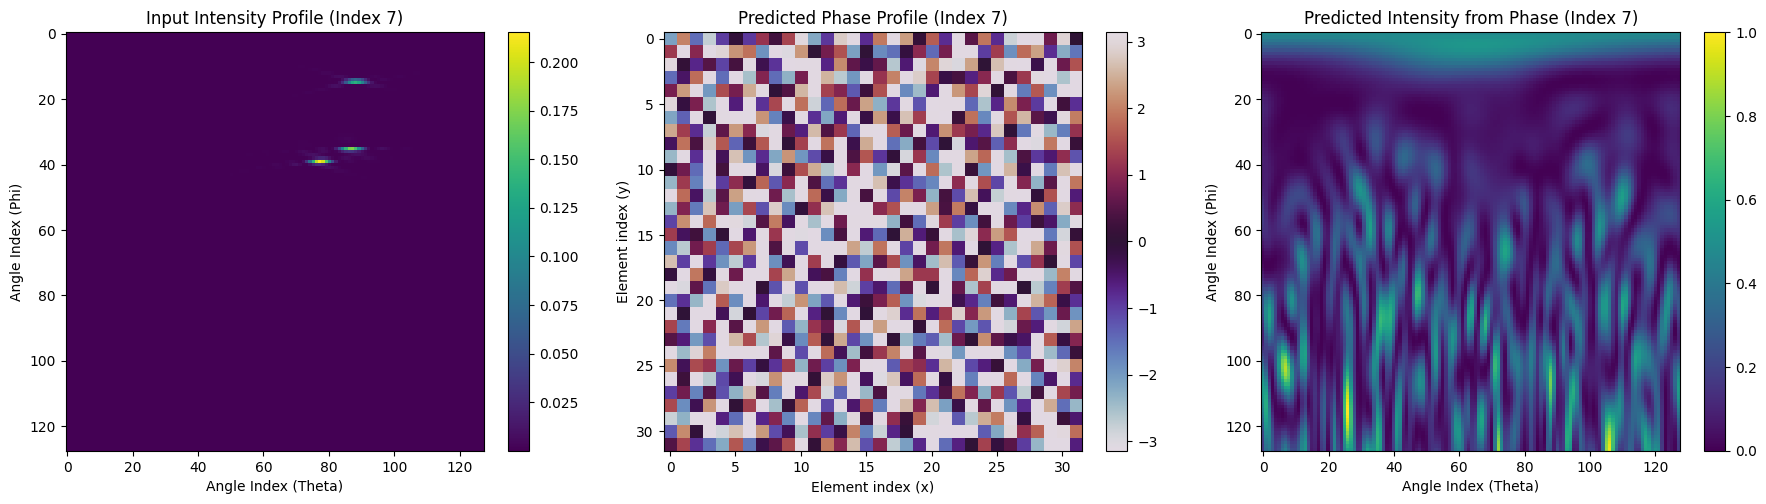

(32, 32)


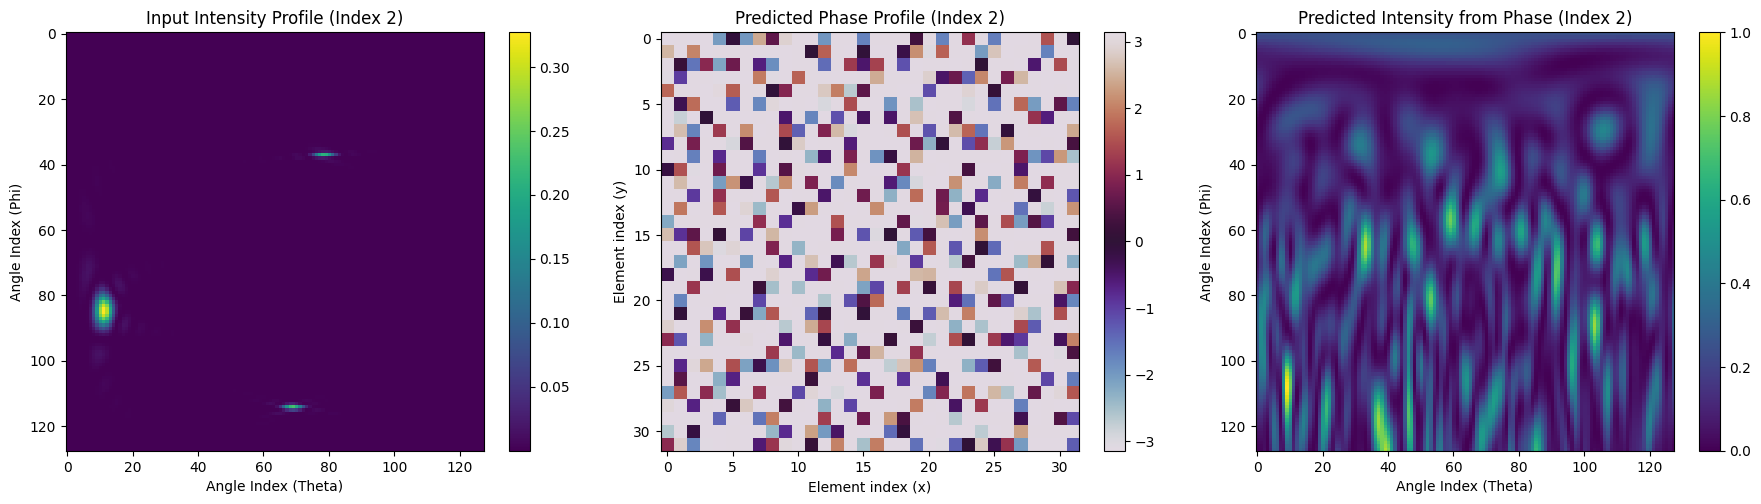

(32, 32)


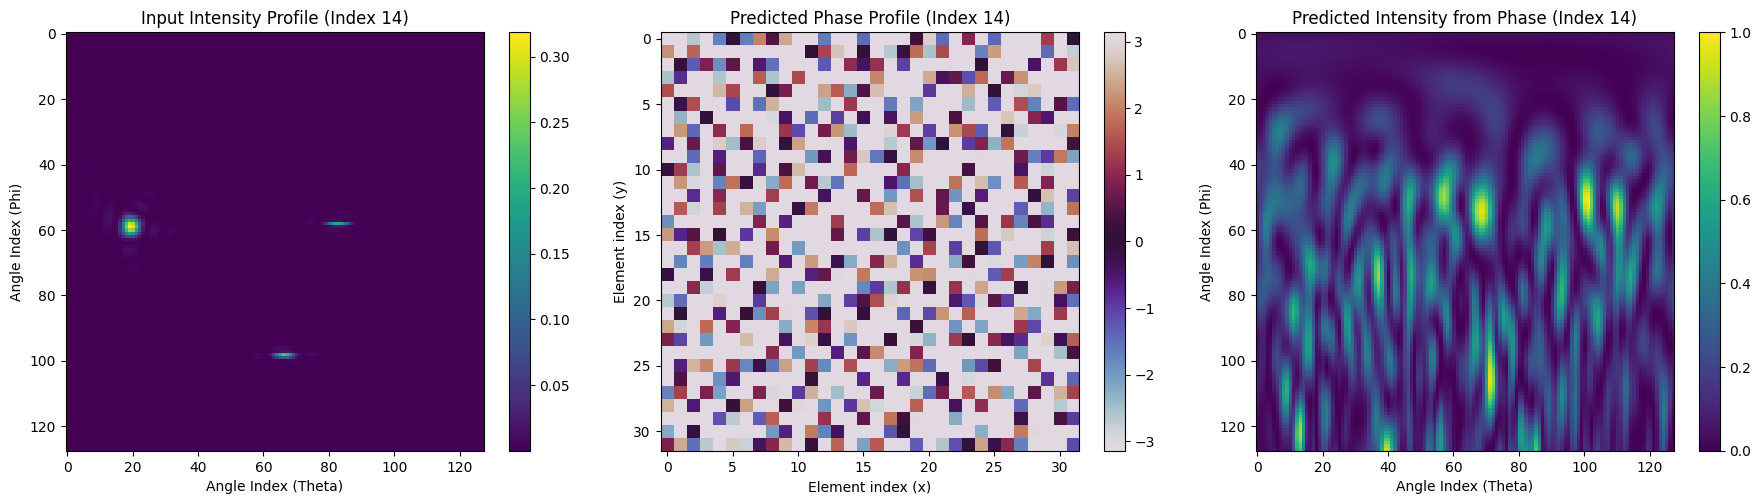

(32, 32)


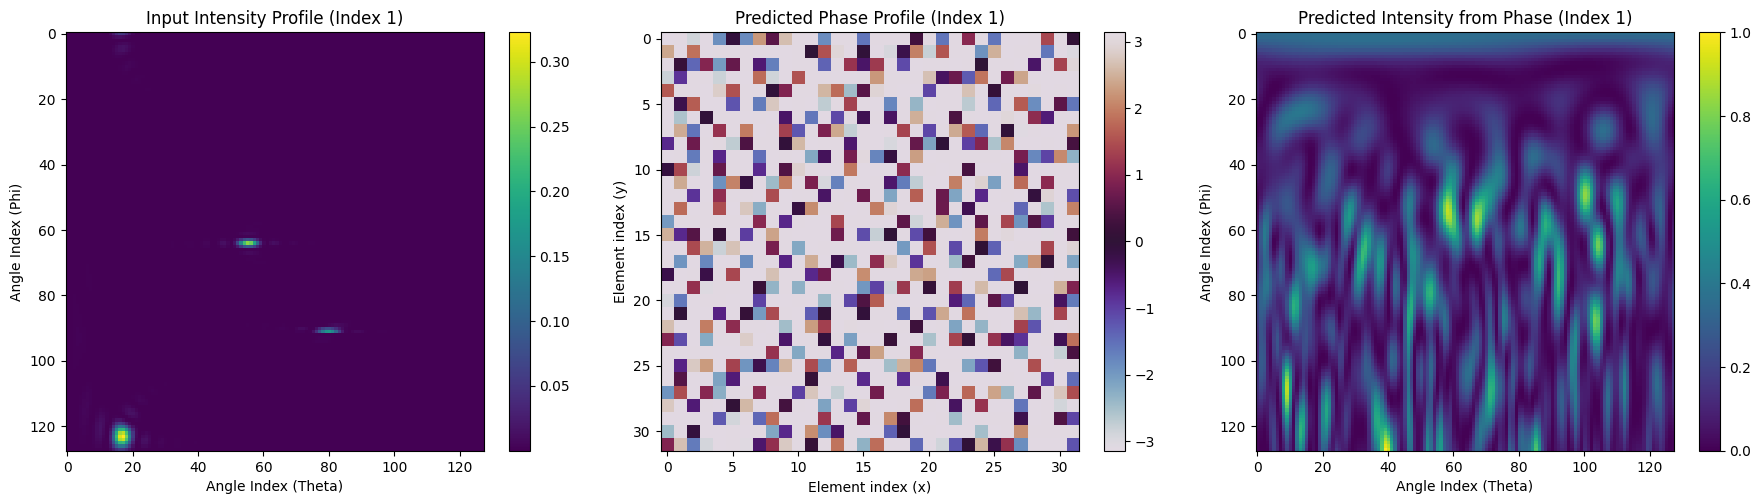

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume these are loaded from your dataset/model output:
# input_intensity: (20,128,128)
# predicted_phase: (20,32,32)
# phase_intensity function from your code converts phase (32,32) to intensity (128,128)

# Replace below dummy with actual tensors converted numpy arrays as needed
input_intensity =test_data
predicted_phase = output

# Your function for far-field intensity calculation (converted tensor to numpy)
def precise_farfield_intensity(phase_matrix, r_m, r_n, k=2*np.pi):
    # Inputs: phase_matrix(32x32), r_m and r_n arrays with length 32, output: intensity (128x128)
    resolution = 128
    theta = np.linspace(0, np.deg2rad(60), resolution)
    phi = np.linspace(0, np.deg2rad(360), resolution)
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

    intens = np.zeros_like(theta_grid, dtype=complex)
    for i in range(len(r_m)):
        for j in range(len(r_n)):
            phasor = (k * np.sin(theta_grid) * (r_m[i]*np.cos(phi_grid) + r_n[j]*np.sin(phi_grid)) - phase_matrix[i, j])
            intens += np.exp(1j * phasor)

    intensensity = (np.abs(intens)**2) * (np.cos(theta_grid)**2)
    intensensity /= np.max(intensensity)  # Normalize intensity
    return intensensity

# r_m, r_n arrays from your provided parameters
M, N, d = 32, 32, 1/4
r_m = np.linspace(0, M*d, M)
r_n = np.linspace(0, N*d, N)

# Select 4 random indices out of the 20
indices = np.random.choice(20, 4, replace=False)

for idx in indices:
    inp_intensity = input_intensity[idx].reshape(128, 128)
    
    pred_phase = predicted_phase[idx].reshape(32,32)
    print(pred_phase.shape)
    # Compute predicted intensity from phase
    pred_intensity = precise_farfield_intensity(pred_phase, r_m, r_n)

    fig = plt.figure(figsize=(18, 5))

    # Input Intensity heatmap (128x128)
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(inp_intensity, cmap='viridis')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    ax1.set_title(f'Input Intensity Profile (Index {idx})')
    ax1.set_xlabel('Angle Index (Theta)')
    ax1.set_ylabel('Angle Index (Phi)')

    # Output Phase heatmap (32x32)
    ax2 = fig.add_subplot(1, 3, 2)
    im2 = ax2.imshow(pred_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    ax2.set_title(f'Predicted Phase Profile (Index {idx})')
    ax2.set_xlabel('Element index (x)')
    ax2.set_ylabel('Element index (y)')

    # Predicted Intensity heatmap (128x128)
    ax3 = fig.add_subplot(1, 3, 3)
    im3 = ax3.imshow(pred_intensity, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(im3, ax=ax3, fraction=0.046)
    ax3.set_title(f'Predicted Intensity from Phase (Index {idx})')
    ax3.set_xlabel('Angle Index (Theta)')
    ax3.set_ylabel('Angle Index (Phi)')

    plt.tight_layout()
    plt.show()


In [50]:
import torch
import torch.nn as nn

# ======= Ensure these values match your training setup =======
resolution = 128        # for example
M = 32                  # for example
N = 32                  # make sure N is set to the correct value
checkpoint_path = "checkpoint_before_compltraining%3A 0.0001_32_128.pth"
# ============================================================

# Model definition with parameterized input
class THzmodel(nn.Module):
    def __init__(self, resolution, M, N):
        super().__init__()
        self.layer1 = nn.Linear(resolution * resolution, 4096)
        self.layer2 = nn.Linear(4096, 4096)
        self.layer3 = nn.Linear(4096, M * N)
        self.activation = nn.LeakyReLU(0.01)
        self.init_weights()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Initialize model
model = THzmodel(resolution, M, N)

# Load checkpoint dictionary
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Check if checkpoint is a dict with 'model_state_dict'
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint  # in case you saved only the state_dict

# Load state dict into the model
model.load_state_dict(state_dict)

# Set model to evaluation mode
model.eval()



# Inference
with torch.no_grad():
    output = model(test_data)
    print("Model output:", output)
    print(output.shape)
    output = output.numpy()
    


C:\Users\binda\AppData\Local\Temp\ipykernel_18756\1288597940.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu'

Model output: tensor([[ 4.4099,  0.5069, -1.6372,  ...,  3.0947,  1.6367,  4.3953],
        [ 7.5895,  0.8778, -2.8082,  ...,  5.3214,  2.8298,  7.5684],
        [ 7.8753,  0.9224, -2.9520,  ...,  5.5222,  2.9404,  7.8471],
        ...,
        [ 7.0746,  0.8331, -2.6216,  ...,  4.9382,  2.6529,  7.0522],
        [ 5.7987,  0.6875, -2.1573,  ...,  4.0539,  2.1702,  5.7711],
        [ 3.5148,  0.4162, -1.3044,  ...,  2.4642,  1.3174,  3.5087]])
torch.Size([20, 1024])


(32, 32)


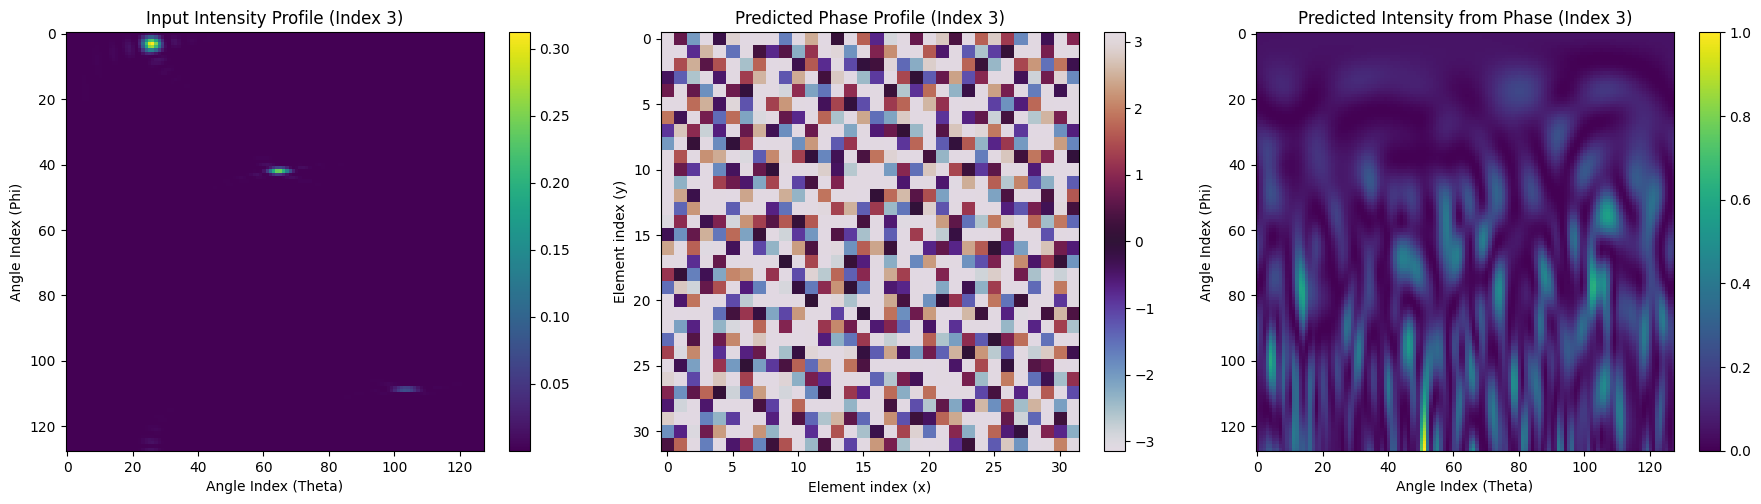

(32, 32)


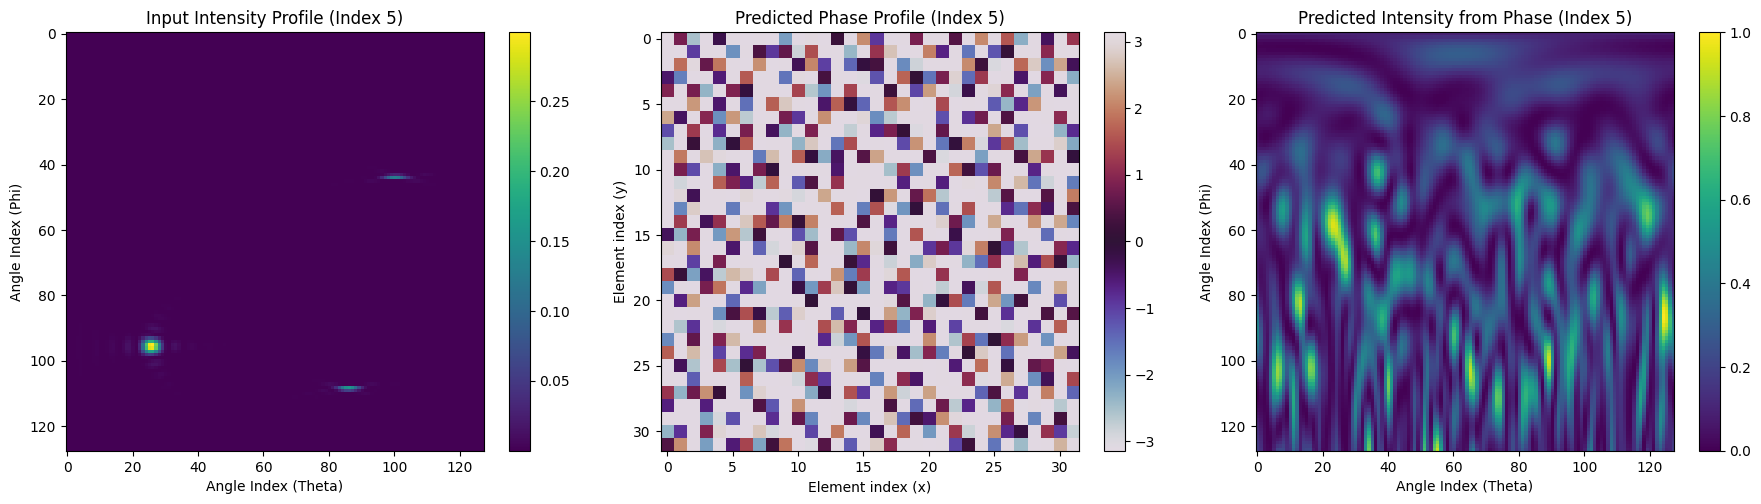

(32, 32)


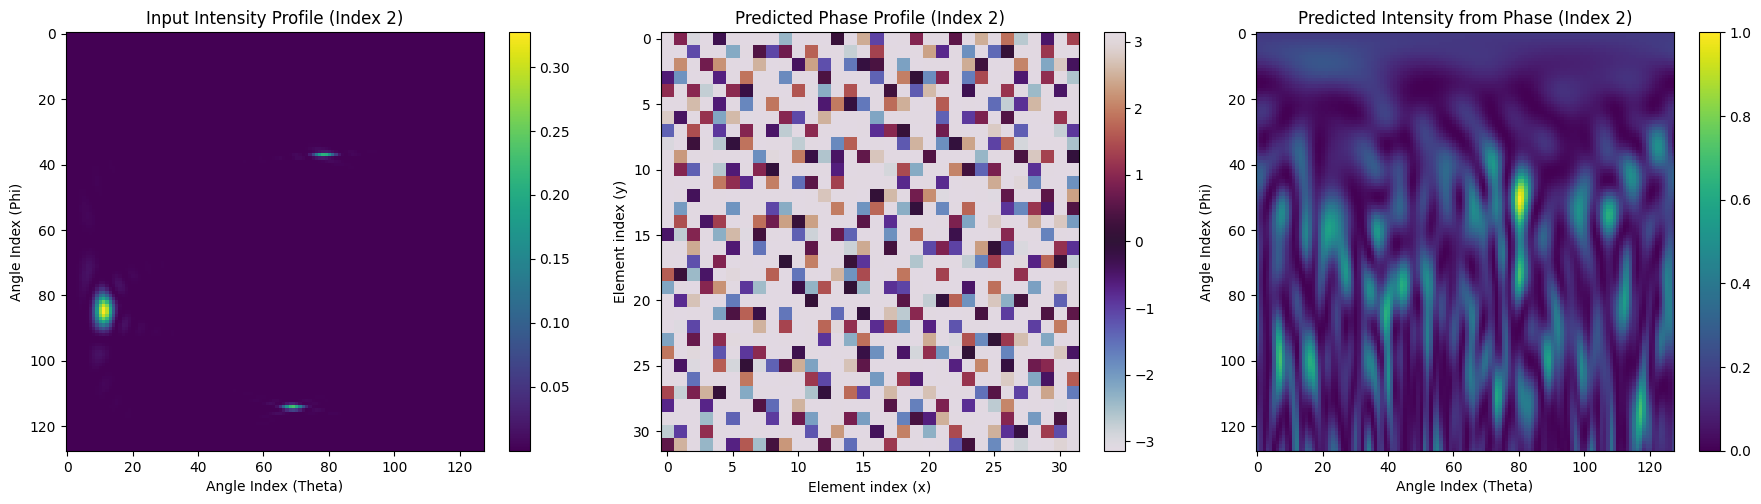

(32, 32)


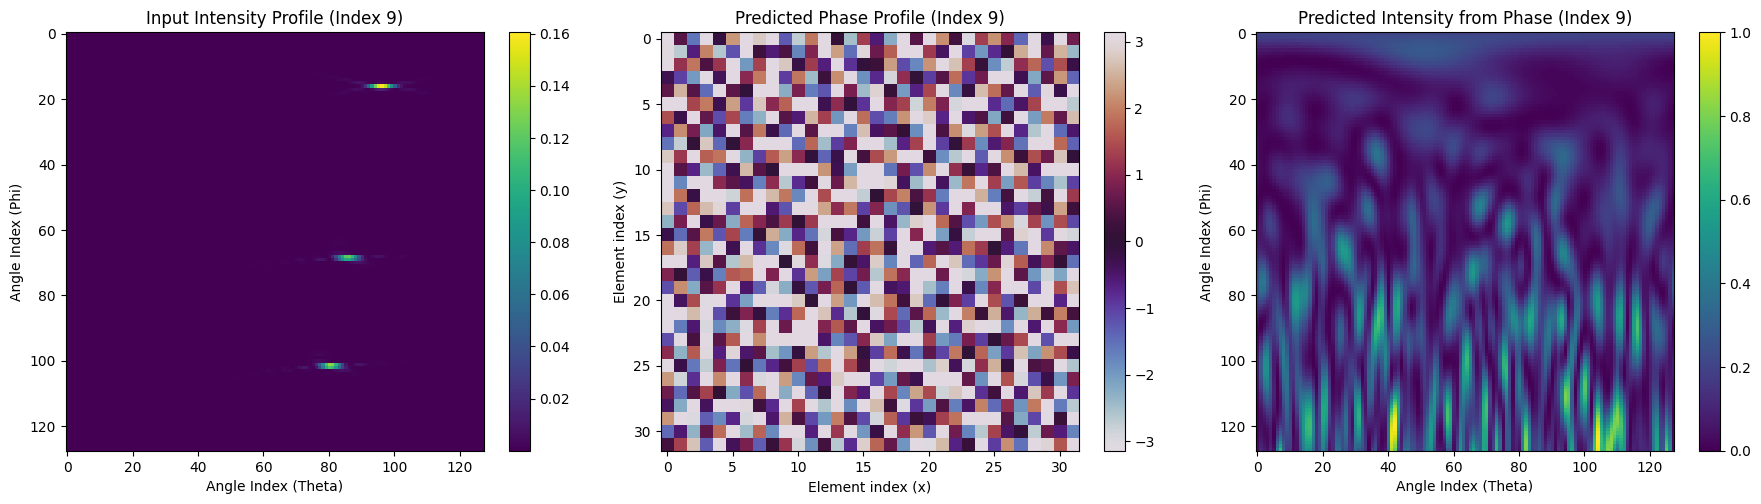

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume these are loaded from your dataset/model output:
# input_intensity: (20,128,128)
# predicted_phase: (20,32,32)
# phase_intensity function from your code converts phase (32,32) to intensity (128,128)

# Replace below dummy with actual tensors converted numpy arrays as needed
input_intensity =test_data
predicted_phase = output

# Your function for far-field intensity calculation (converted tensor to numpy)
def precise_farfield_intensity(phase_matrix, r_m, r_n, k=2*np.pi):
    # Inputs: phase_matrix(32x32), r_m and r_n arrays with length 32, output: intensity (128x128)
    resolution = 128
    theta = np.linspace(0, np.deg2rad(60), resolution)
    phi = np.linspace(0, np.deg2rad(360), resolution)
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

    intens = np.zeros_like(theta_grid, dtype=complex)
    for i in range(len(r_m)):
        for j in range(len(r_n)):
            phasor = (k * np.sin(theta_grid) * (r_m[i]*np.cos(phi_grid) + r_n[j]*np.sin(phi_grid)) - phase_matrix[i, j])
            intens += np.exp(1j * phasor)

    intensensity = (np.abs(intens)**2) * (np.cos(theta_grid)**2)
    intensensity /= np.max(intensensity)  # Normalize intensity
    return intensensity

# r_m, r_n arrays from your provided parameters
M, N, d = 32, 32, 1/4
r_m = np.linspace(0, M*d, M)
r_n = np.linspace(0, N*d, N)

# Select 4 random indices out of the 20
indices = np.random.choice(20, 4, replace=False)

for idx in indices:
    inp_intensity = input_intensity[idx].reshape(128, 128)
    
    pred_phase = predicted_phase[idx].reshape(32,32)
    print(pred_phase.shape)
    # Compute predicted intensity from phase
    pred_intensity = precise_farfield_intensity(pred_phase, r_m, r_n)

    fig = plt.figure(figsize=(18, 5))

    # Input Intensity heatmap (128x128)
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(inp_intensity, cmap='viridis')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    ax1.set_title(f'Input Intensity Profile (Index {idx})')
    ax1.set_xlabel('Angle Index (Theta)')
    ax1.set_ylabel('Angle Index (Phi)')

    # Output Phase heatmap (32x32)
    ax2 = fig.add_subplot(1, 3, 2)
    im2 = ax2.imshow(pred_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    ax2.set_title(f'Predicted Phase Profile (Index {idx})')
    ax2.set_xlabel('Element index (x)')
    ax2.set_ylabel('Element index (y)')

    # Predicted Intensity heatmap (128x128)
    ax3 = fig.add_subplot(1, 3, 3)
    im3 = ax3.imshow(pred_intensity, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(im3, ax=ax3, fraction=0.046)
    ax3.set_title(f'Predicted Intensity from Phase (Index {idx})')
    ax3.set_xlabel('Angle Index (Theta)')
    ax3.set_ylabel('Angle Index (Phi)')

    plt.tight_layout()
    plt.show()
